In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from utils import ffmpeg_load_audio, list_all_files
from multiprocessing import Pool
from librosa.feature import rmse, spectral_centroid, spectral_rolloff, spectral_bandwidth, chroma_cqt
import librosa
import numpy as np

In [2]:
def get_median_feature(feature, env):
    return np.median(feature[:, env > env.mean()], axis=1)

In [3]:
def get_stats(y, sr, hop_length=256):
    results = {}
    S, phase = librosa.magphase(librosa.stft(y=y, n_fft=2048, hop_length=hop_length))
    env = np.array(rmse(S=S).reshape(-1))
    peak = env.argmax()
    cs = np.cumsum(env)
    cs /= cs.max()
    return {
        'peak': hop_length * peak,
        'percentiles': [
            hop_length * (np.searchsorted(cs, 0.1) - peak),
            hop_length * (np.searchsorted(cs, 0.5) - peak),
            hop_length * (np.searchsorted(cs, 0.9) - peak)
        ],
        'power': env.sum(),
        'centroid': get_median_feature(spectral_centroid(S=S), env)[0],
        'rolloff': get_median_feature(spectral_rolloff(S=S), env)[0],
        'bandwidth': get_median_feature(spectral_bandwidth(S=S), env)[0],
        'chroma': get_median_feature(chroma_cqt(y=y, sr=sr, hop_length=hop_length, tuning=0), env)
    }

In [9]:
# this is how you run it from a .npy file
data_root = 'data/freesound'
sr=44100
%time samples = np.load(data_root + '/samples.npy')
def job(y):
    return get_stats(y, sr)
p = Pool(8)
%time analysis = p.map(job, samples)

CPU times: user 10.5 s, sys: 20.4 s, total: 30.9 s
Wall time: 7min 34s


In [ ]:
# this is how you run it from a directory of files
data_root = 'data/birds'
sr=44100
files = list(list_all_files(data_root, ['.wav']))
def job(fn):
    y, sr = ffmpeg_load_audio(fn, normalize=False, mono=True) # assume already normalized
    return get_stats(y, sr)
p = Pool(4)
%time analysis = p.map(job, files[:100])

In [101]:
cur = analysis[0]

{'bandwidth': 1292.6386534175549,
 'centroid': 894.37042656718609,
 'chroma': array([ 0.95016089,  0.77194086,  0.86583409,  0.63434566,  0.68312755,
         0.56335354,  0.57833891,  0.74762972,  0.57595208,  0.3840178 ,
         0.50416515,  0.43918487]),
 'peak': 7936,
 'percentiles': [-3584, 1792, 8704],
 'power': 432.89825,
 'rolloff': 2024.12109375}

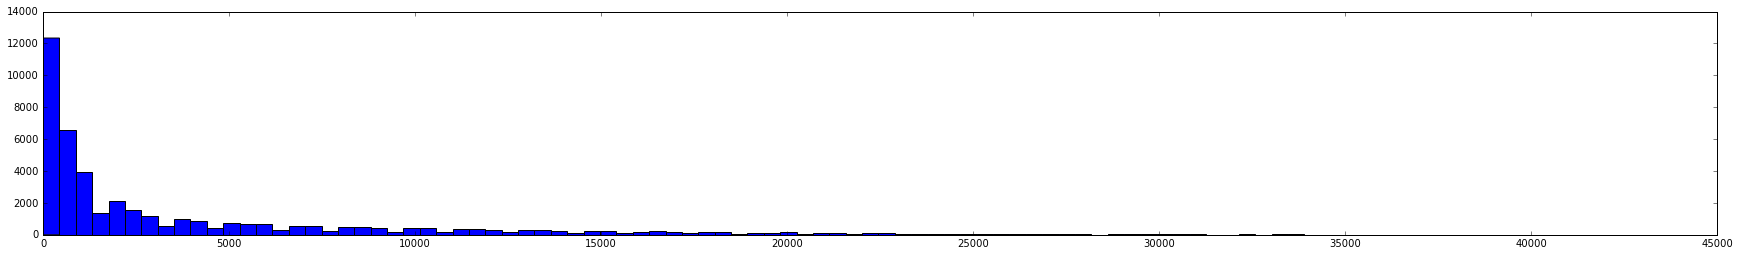

In [17]:
plt.figure(figsize=(30,4))
plt.hist([x['peak'] for x in analysis], bins=100)
plt.show()

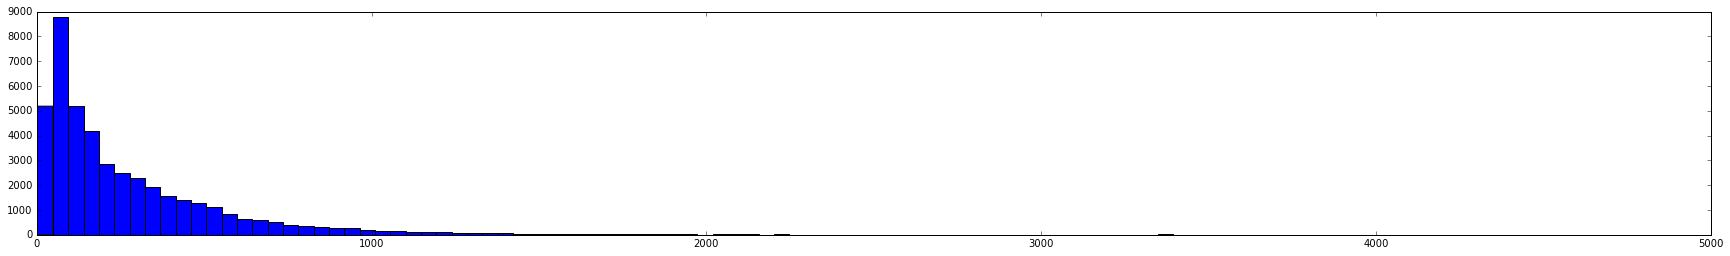

In [18]:
plt.figure(figsize=(30,4))
plt.hist([x['power'] for x in analysis], bins=100)
plt.show()

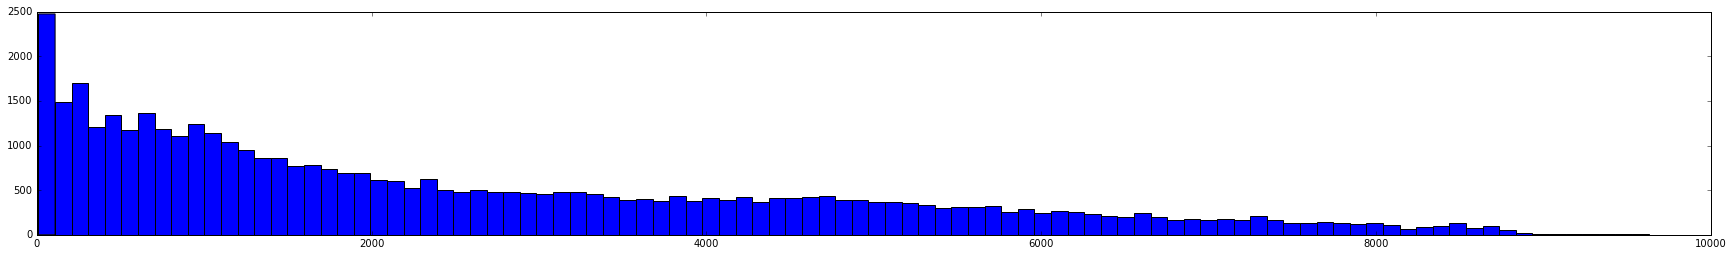

In [19]:
plt.figure(figsize=(30,4))
plt.hist([x['rolloff'] for x in analysis], bins=100)
plt.show()

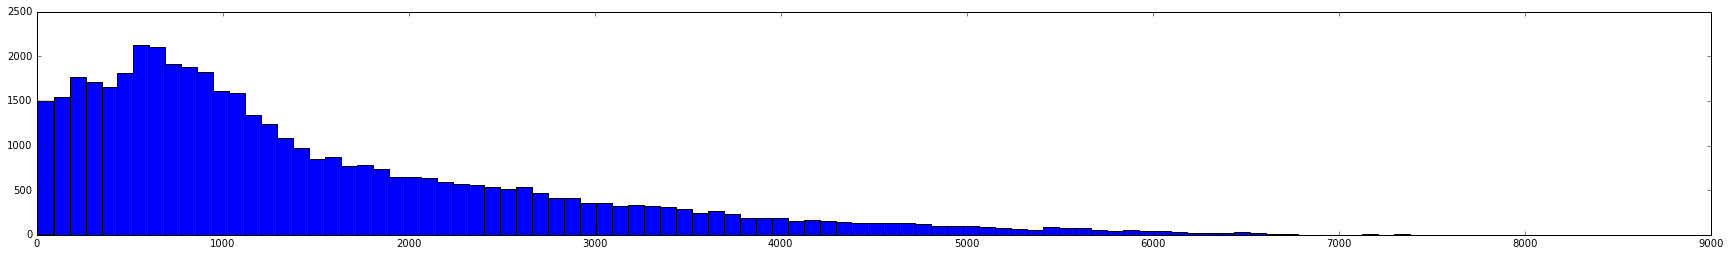

In [20]:
plt.figure(figsize=(30,4))
plt.hist([x['centroid'] for x in analysis], bins=100)
plt.show()

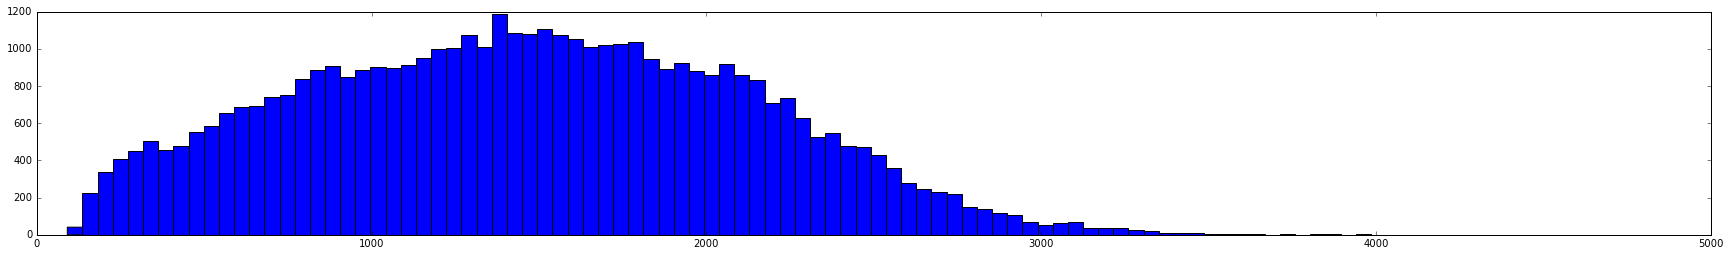

In [21]:
plt.figure(figsize=(30,4))
plt.hist([x['bandwidth'] for x in analysis], bins=100)
plt.show()

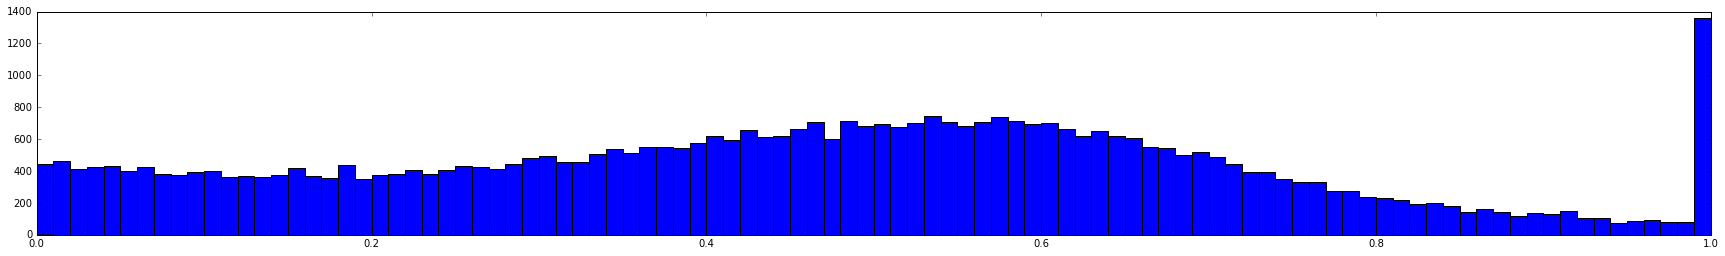

In [26]:
plt.figure(figsize=(30,4))
plt.hist([x['chroma'][6] for x in analysis], bins=100)
plt.show()

In [14]:
import cPickle as pickle
with open(data_root + '/analysis.pkl', 'w') as f:
    pickle.dump(analysis, f, -1)